In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate, BatchNormalization, Activation
from tensorflow.keras import Model

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt

# TASK2

# U-net construction

In [3]:
def conv_block(inputs, n_filters, dropout_prob, max_pooling, batch_normalization):
    
    ### START CODE HERE
    conv = Conv2D(filters = n_filters, kernel_size = (3,3), strides=(1,1), padding='same')(inputs)
    if batch_normalization:
        Batch = BatchNormalization()(conv)
        Act = Activation('relu')(Batch)
    else:
        Act = Activation('relu')(conv)
        
    conv = Conv2D(filters = n_filters, # Number of filters
                  kernel_size = (3,3),   # Kernel size   
                  strides=(1,1),
                  padding='same')(Act)
    if batch_normalization:
        Batch = BatchNormalization()(conv)
        Act = Activation('relu')(Batch)
    else:
        Act = Activation('relu')(conv)
    ### END CODE HERE
    
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(pool_size=(2,2))(Act)
        ### END CODE HERE
        
    else:
        next_layer = Act
    
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        last_layer = Dropout(dropout_prob)(next_layer)
    else:
        last_layer = next_layer
        
         ### END CODE HERE
    
    return Act, last_layer

In [4]:
def decoder_block(inputs, n_filters, dropout_prob, cblock, batch_normalization):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv_T = Conv2DTranspose(filters = n_filters, # Number of filters
                  kernel_size = (3,3),   # Kernel size   
                  strides=(2,2),
                  padding='same')(inputs)
    Concate = concatenate([conv_T,cblock])
    ### END CODE HERE

    
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        next_layer = Dropout(dropout_prob)(Concate)
    else:
        next_layer = Concate
        
    Temp, Act = conv_block(next_layer, n_filters, dropout_prob, False, batch_normalization)        
        
        
         ### END CODE HERE
    
    return Act

In [4]:
def get_unet(img_ch, img_width, img_height, n_filters, dropout, batch_normalization,
             max_pooling = True, binary = True, class_num = 2):
    inputs = Input(shape=(img_width, img_height, img_ch))
    c1,cblock1 = conv_block(inputs, n_filters * 1, dropout, max_pooling, batch_normalization) 
    c2,cblock2 = conv_block(cblock1, n_filters * 2, dropout, max_pooling, batch_normalization)
    c3,cblock3 = conv_block(cblock2, n_filters * 4, dropout, max_pooling, batch_normalization)
    c4,cblock4 = conv_block(cblock3, n_filters * 8, dropout, max_pooling, batch_normalization)
    ## Nottlenect block
    temp,cblock5 = conv_block(cblock4, n_filters * 16, dropout, False, False)
    ## Decoder 
    cblock6 = decoder_block(cblock5, n_filters * 8, dropout, c4, batch_normalization)
    cblock7 = decoder_block(cblock6, n_filters * 4, dropout, c3, batch_normalization)
    cblock8 = decoder_block(cblock7, n_filters * 2, dropout, c2, batch_normalization)
    cblock9 = decoder_block(cblock8, n_filters * 1, dropout, c1, batch_normalization)
    #Output
    if binary:
        out = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same', activation = 'sigmoid')(cblock9)
    else:
        out = Conv2D(filters=class_num, kernel_size=(3,3), strides=(1,1), padding='same', activation = 'sigmoid')(cblock9)
        
    clf = Model(inputs=inputs, outputs=out)
    clf.summary()
    
    return clf    

# Data loading

In [5]:
import os
import numpy as np
from random import shuffle
from skimage.io import imread
from skimage.transform import resize

In [6]:
def get_mask(data_path, mask_labels, img_h, img_w, split_ratio):
    """
    Parameters
    ----------
    data_path : Str
        Path to the data directory
    mask_labels : List
        A list containing the name of the mask files.
    img_h : Int
        image height to be resized to.
    img_w : Int
        image width to be resized to.    
    split_ratio : Float
        Ratio between 0 and 1 giving the proportion of train 
    Returns
    -------
    mask : List
        A list containing the mask images along with their
        corresponding labels.
    """
    
    mask_list = []
    for label in mask_labels:
        mask = imread(data_path + 'Mask/' + label, as_gray = True) # "as_grey"
        mask = resize(mask, (img_h, img_w), anti_aliasing = True).astype('float32')
        mask_list.append([np.array(mask), label])
    shuffle(mask_list)
    train_mask_list = mask_list[:int(split_ratio*len(mask_list))]
    test_mask_list = mask_list[int(split_ratio*len(mask_list)):]
    return train_mask_list, test_mask_list


def get_data(data_path, mask_labels, img_h, img_w, split_ratio = 0.8):
    
    #Loading the shuffled and splitted lists of mask images with their corresponding labels
    train_mask_list, test_mask_list = get_mask(data_path, mask_labels, img_h, img_w, split_ratio)
    
    #Initialising the train arrays
    train_img = np.zeros((len(train_mask_list), img_h, img_w), dtype = np.float32)
    train_mask = np.zeros((len(train_mask_list), img_h, img_w), dtype = np.float32)
    for ind in range(len(train_mask_list)):
        #Adding the mask in the ytrain array
        train_mask[ind] = train_mask_list[ind][0]
        #Adding the corresponding image in the xtrain array
        label = train_mask_list[ind][1]
        label_image = label[0:-9] + '.png'
        img = imread(data_path + 'Image/' + label_image, as_gray = True) # "as_grey"
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        train_img[ind] = (np.array(img)-np.min(np.array(img)))/(np.max(np.array(img))-np.min(np.array(img)))
        #Print the advancement
        if ind%10==0:
            a = ind/len(train_mask_list)
            print('Train dataset : ', str(int(100*a)), '%')
        elif ind+1 == len(train_mask_list):
            print('Train dataset : 100%')
    train_img = np.expand_dims(train_img, axis =3)
    train_mask = np.expand_dims(train_mask, axis =3)
    
    #Initialising the test arrays
    test_img = np.zeros((len(test_mask_list), img_h, img_w), dtype = np.float32)
    test_mask = np.zeros((len(test_mask_list), img_h, img_w), dtype = np.float32)
    for ind in range(len(test_mask_list)):
        #Adding the mask in the ytest array
        test_mask[ind] = test_mask_list[ind][0]
        #Adding the corresponding image in the xtest array
        label = test_mask_list[ind][1]
        label_image = label[0:-9] + '.png'
        img = imread(data_path + 'Image/' + label_image, as_gray = True) # "as_grey"
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        test_img[ind] = (np.array(img)-np.min(np.array(img)))/(np.max(np.array(img))-np.min(np.array(img)))
        #Print the advancement
        if ind%10==0:
            a = ind/len(test_mask_list)
            print('Test dataset : ', str(int(100*a)), '%')
        elif ind+1 == len(test_mask_list):
            print('Test dataset : 100%')

    test_img = np.expand_dims(test_img, axis =3)
    test_mask = np.expand_dims(test_mask, axis =3)
    
    return train_img, train_mask, test_img, test_mask, img
    
    

In [7]:
img_w, img_h = 256, 256 
data_path = '/DL_course_data/Lab3/CT/'
mask_labels = os.listdir(data_path + 'Mask/')
x_train, y_train, x_test, y_test, test_img = get_data(data_path, mask_labels, img_h, img_w, split_ratio = 0.8)

Train dataset :  0 %
Train dataset :  0 %
Train dataset :  0 %
Train dataset :  0 %
Train dataset :  0 %
Train dataset :  0 %
Train dataset :  0 %
Train dataset :  1 %
Train dataset :  1 %
Train dataset :  1 %
Train dataset :  1 %
Train dataset :  1 %
Train dataset :  1 %
Train dataset :  1 %
Train dataset :  2 %
Train dataset :  2 %
Train dataset :  2 %
Train dataset :  2 %
Train dataset :  2 %
Train dataset :  2 %
Train dataset :  2 %
Train dataset :  3 %
Train dataset :  3 %
Train dataset :  3 %
Train dataset :  3 %
Train dataset :  3 %
Train dataset :  3 %
Train dataset :  4 %
Train dataset :  4 %
Train dataset :  4 %
Train dataset :  4 %
Train dataset :  4 %
Train dataset :  4 %
Train dataset :  4 %
Train dataset :  5 %
Train dataset :  5 %
Train dataset :  5 %
Train dataset :  5 %
Train dataset :  5 %
Train dataset :  5 %
Train dataset :  5 %
Train dataset :  6 %
Train dataset :  6 %
Train dataset :  6 %
Train dataset :  6 %
Train dataset :  6 %
Train dataset :  6 %
Train dataset

Train dataset :  55 %
Train dataset :  55 %
Train dataset :  56 %
Train dataset :  56 %
Train dataset :  56 %
Train dataset :  56 %
Train dataset :  56 %
Train dataset :  56 %
Train dataset :  57 %
Train dataset :  57 %
Train dataset :  57 %
Train dataset :  57 %
Train dataset :  57 %
Train dataset :  57 %
Train dataset :  57 %
Train dataset :  58 %
Train dataset :  58 %
Train dataset :  58 %
Train dataset :  58 %
Train dataset :  58 %
Train dataset :  58 %
Train dataset :  58 %
Train dataset :  59 %
Train dataset :  59 %
Train dataset :  59 %
Train dataset :  59 %
Train dataset :  59 %
Train dataset :  59 %
Train dataset :  59 %
Train dataset :  60 %
Train dataset :  60 %
Train dataset :  60 %
Train dataset :  60 %
Train dataset :  60 %
Train dataset :  60 %
Train dataset :  61 %
Train dataset :  61 %
Train dataset :  61 %
Train dataset :  61 %
Train dataset :  61 %
Train dataset :  61 %
Train dataset :  61 %
Train dataset :  62 %
Train dataset :  62 %
Train dataset :  62 %
Train data

Test dataset :  46 %
Test dataset :  46 %
Test dataset :  47 %
Test dataset :  48 %
Test dataset :  48 %
Test dataset :  49 %
Test dataset :  49 %
Test dataset :  50 %
Test dataset :  51 %
Test dataset :  51 %
Test dataset :  52 %
Test dataset :  52 %
Test dataset :  53 %
Test dataset :  54 %
Test dataset :  54 %
Test dataset :  55 %
Test dataset :  55 %
Test dataset :  56 %
Test dataset :  57 %
Test dataset :  57 %
Test dataset :  58 %
Test dataset :  58 %
Test dataset :  59 %
Test dataset :  59 %
Test dataset :  60 %
Test dataset :  61 %
Test dataset :  61 %
Test dataset :  62 %
Test dataset :  62 %
Test dataset :  63 %
Test dataset :  64 %
Test dataset :  64 %
Test dataset :  65 %
Test dataset :  65 %
Test dataset :  66 %
Test dataset :  67 %
Test dataset :  67 %
Test dataset :  68 %
Test dataset :  68 %
Test dataset :  69 %
Test dataset :  70 %
Test dataset :  70 %
Test dataset :  71 %
Test dataset :  71 %
Test dataset :  72 %
Test dataset :  73 %
Test dataset :  73 %
Test dataset 

In [8]:
x_train.shape

(6735, 256, 256, 1)

In [9]:
test_img.shape

(256, 256)

In [8]:
#Verify the normalization

for image in range(x_test.shape[0]):
    if np.min(x_test[image, :, :, 0])==0:
        pass
    else :
        print('Min image ', image, '=', np.min(x_test[image, :, :, 0]))
    if np.max(x_test[image, :, :, 0])==1:
        pass
    else :
        print('Max image ', image, '=', np.max(x_test[image, :, :, 0]))
    if np.min(y_test[image, :, :, 0])==0:
        pass
    else :
        print('Min image ', image, '=', np.min(y_test[image, :, :, 0]))
    if np.max(y_test[image, :, :, 0])==1:
        pass
    else :
        print('Max image ', image, '=', np.max(y_test[image, :, :, 0]))
print('Test checked')
  
for image in range(x_train.shape[0]):
    if np.min(x_train[image, :, :, 0])==0:
        pass
    else :
        print('Min image ', image, '=', np.min(x_train[image, :, :, 0]))
    if np.max(x_train[image, :, :, 0])==1:
        pass
    else :
        print('Max image ', image, '=', np.max(x_train[image, :, :, 0]))
    if np.min(y_train[image, :, :, 0])==0:
        pass
    else :
        print('Min image ', image, '=', np.min(y_train[image, :, :, 0]))
    if np.max(y_train[image, :, :, 0])==1:
        pass
    else :
        print('Max image ', image, '=', np.max(y_train[image, :, :, 0]))
print('Train checked')    

Max image  0 = 0.98039216
Max image  1 = 0.98039216
Max image  2 = 0.98039216
Max image  3 = 0.98039216
Max image  4 = 0.98039216
Max image  5 = 0.98039216
Max image  6 = 0.98039216
Max image  7 = 0.98039216
Max image  8 = 0.98039216
Max image  9 = 0.98039216
Max image  10 = 0.98039216
Max image  11 = 0.98039216
Max image  12 = 0.98039216
Max image  13 = 0.98039216
Max image  14 = 0.98039216
Max image  15 = 0.98039216
Max image  16 = 0.98039216
Max image  17 = 0.98039216
Max image  18 = 0.98039216
Max image  19 = 0.98039216
Max image  20 = 0.98039216
Max image  21 = 0.98039216
Max image  22 = 0.98039216
Max image  23 = 0.98039216
Max image  24 = 0.98039216
Max image  25 = 0.98039216
Max image  26 = 0.98039216
Max image  27 = 0.98039216
Max image  28 = 0.98039216
Max image  29 = 0.98039216
Max image  30 = 0.98039216
Max image  31 = 0.98039216
Max image  32 = 0.98039216
Max image  33 = 0.98039216
Max image  34 = 0.98039216
Max image  35 = 0.98039216
Max image  36 = 0.98039216
Max image  

Max image  333 = 0.98039216
Max image  334 = 0.98039216
Max image  335 = 0.98039216
Max image  336 = 0.98039216
Max image  337 = 0.98039216
Max image  338 = 0.98039216
Max image  339 = 0.98039216
Max image  340 = 0.98039216
Max image  341 = 0.98039216
Max image  342 = 0.98039216
Max image  343 = 0.98039216
Max image  344 = 0.98039216
Max image  345 = 0.98039216
Max image  346 = 0.98039216
Max image  347 = 0.98039216
Max image  348 = 0.98039216
Max image  349 = 0.98039216
Max image  350 = 0.98039216
Max image  351 = 0.98039216
Max image  352 = 0.98039216
Max image  353 = 0.98039216
Max image  354 = 0.98039216
Max image  355 = 0.98039216
Max image  356 = 0.98039216
Max image  357 = 0.98039216
Max image  358 = 0.98039216
Max image  359 = 0.98039216
Max image  360 = 0.98039216
Max image  361 = 0.98039216
Max image  362 = 0.98039216
Max image  363 = 0.98039216
Max image  364 = 0.98039216
Max image  365 = 0.98039216
Max image  366 = 0.98039216
Max image  367 = 0.98039216
Max image  368 = 0.9

Max image  709 = 0.98039216
Max image  710 = 0.98039216
Max image  711 = 0.98039216
Max image  712 = 0.98039216
Max image  713 = 0.98039216
Max image  714 = 0.98039216
Max image  715 = 0.98039216
Max image  716 = 0.98039216
Max image  717 = 0.98039216
Max image  718 = 0.98039216
Max image  719 = 0.98039216
Max image  720 = 0.98039216
Max image  721 = 0.98039216
Max image  722 = 0.98039216
Max image  723 = 0.98039216
Max image  724 = 0.98039216
Max image  725 = 0.98039216
Max image  726 = 0.98039216
Max image  727 = 0.98039216
Max image  728 = 0.98039216
Max image  729 = 0.98039216
Max image  730 = 0.98039216
Max image  731 = 0.98039216
Max image  732 = 0.98039216
Max image  733 = 0.98039216
Max image  734 = 0.98039216
Max image  735 = 0.98039216
Max image  736 = 0.98039216
Max image  737 = 0.98039216
Max image  738 = 0.98039216
Max image  739 = 0.98039216
Max image  740 = 0.98039216
Max image  741 = 0.98039216
Max image  742 = 0.98039216
Max image  743 = 0.98039216
Max image  744 = 0.9

Max image  1025 = 0.98039216
Max image  1026 = 0.98039216
Max image  1027 = 0.98039216
Max image  1028 = 0.98039216
Max image  1029 = 0.98039216
Max image  1030 = 0.98039216
Max image  1031 = 0.98039216
Max image  1032 = 0.98039216
Max image  1033 = 0.98039216
Max image  1034 = 0.98039216
Max image  1035 = 0.98039216
Max image  1036 = 0.98039216
Max image  1037 = 0.98039216
Max image  1038 = 0.98039216
Max image  1039 = 0.98039216
Max image  1040 = 0.98039216
Max image  1041 = 0.98039216
Max image  1042 = 0.98039216
Max image  1043 = 0.98039216
Max image  1044 = 0.98039216
Max image  1045 = 0.98039216
Max image  1046 = 0.98039216
Max image  1047 = 0.98039216
Max image  1048 = 0.98039216
Max image  1049 = 0.98039216
Max image  1050 = 0.98039216
Max image  1051 = 0.98039216
Max image  1052 = 0.98039216
Max image  1053 = 0.98039216
Max image  1054 = 0.98039216
Max image  1055 = 0.98039216
Max image  1056 = 0.98039216
Max image  1057 = 0.98039216
Max image  1058 = 0.98039216
Max image  105

Max image  1432 = 0.98039216
Max image  1433 = 0.98039216
Max image  1434 = 0.98039216
Max image  1435 = 0.98039216
Max image  1436 = 0.98039216
Max image  1437 = 0.98039216
Max image  1438 = 0.98039216
Max image  1439 = 0.98039216
Max image  1440 = 0.98039216
Max image  1441 = 0.98039216
Max image  1442 = 0.98039216
Max image  1443 = 0.98039216
Max image  1444 = 0.98039216
Max image  1445 = 0.98039216
Max image  1446 = 0.98039216
Max image  1447 = 0.98039216
Max image  1448 = 0.98039216
Max image  1449 = 0.98039216
Max image  1450 = 0.98039216
Max image  1451 = 0.98039216
Max image  1452 = 0.98039216
Max image  1453 = 0.98039216
Max image  1454 = 0.98039216
Max image  1455 = 0.98039216
Max image  1456 = 0.98039216
Max image  1457 = 0.98039216
Max image  1458 = 0.98039216
Max image  1459 = 0.98039216
Max image  1460 = 0.98039216
Max image  1461 = 0.98039216
Max image  1462 = 0.98039216
Max image  1463 = 0.98039216
Max image  1464 = 0.98039216
Max image  1465 = 0.98039216
Max image  146

Max image  74 = 0.98039216
Max image  75 = 0.98039216
Max image  76 = 0.98039216
Max image  77 = 0.98039216
Max image  78 = 0.98039216
Max image  79 = 0.98039216
Max image  80 = 0.98039216
Max image  81 = 0.98039216
Max image  82 = 0.98039216
Max image  83 = 0.98039216
Max image  84 = 0.98039216
Max image  85 = 0.98039216
Max image  86 = 0.98039216
Max image  87 = 0.98039216
Max image  88 = 0.98039216
Max image  89 = 0.98039216
Max image  90 = 0.98039216
Max image  91 = 0.98039216
Max image  92 = 0.98039216
Max image  93 = 0.98039216
Max image  94 = 0.98039216
Max image  95 = 0.98039216
Max image  96 = 0.98039216
Max image  97 = 0.98039216
Max image  98 = 0.98039216
Max image  99 = 0.98039216
Max image  100 = 0.98039216
Max image  101 = 0.98039216
Max image  102 = 0.98039216
Max image  103 = 0.98039216
Max image  104 = 0.98039216
Max image  105 = 0.98039216
Max image  106 = 0.98039216
Max image  107 = 0.98039216
Max image  108 = 0.98039216
Max image  109 = 0.98039216
Max image  110 = 0

Max image  430 = 0.98039216
Max image  431 = 0.98039216
Max image  432 = 0.98039216
Max image  433 = 0.98039216
Max image  434 = 0.98039216
Max image  435 = 0.98039216
Max image  436 = 0.98039216
Max image  437 = 0.98039216
Max image  438 = 0.98039216
Max image  439 = 0.98039216
Max image  440 = 0.98039216
Max image  441 = 0.98039216
Max image  442 = 0.98039216
Max image  443 = 0.98039216
Max image  444 = 0.98039216
Max image  445 = 0.98039216
Max image  446 = 0.98039216
Max image  447 = 0.98039216
Max image  448 = 0.98039216
Max image  449 = 0.98039216
Max image  450 = 0.98039216
Max image  451 = 0.98039216
Max image  452 = 0.98039216
Max image  453 = 0.98039216
Max image  454 = 0.98039216
Max image  455 = 0.98039216
Max image  456 = 0.98039216
Max image  457 = 0.98039216
Max image  458 = 0.98039216
Max image  459 = 0.98039216
Max image  460 = 0.98039216
Max image  461 = 0.98039216
Max image  462 = 0.98039216
Max image  463 = 0.98039216
Max image  464 = 0.98039216
Max image  465 = 0.9

Max image  736 = 0.98039216
Max image  737 = 0.98039216
Max image  738 = 0.98039216
Max image  739 = 0.98039216
Max image  740 = 0.98039216
Max image  741 = 0.98039216
Max image  742 = 0.98039216
Max image  743 = 0.98039216
Max image  744 = 0.98039216
Max image  745 = 0.98039216
Max image  746 = 0.98039216
Max image  747 = 0.98039216
Max image  748 = 0.98039216
Max image  749 = 0.98039216
Max image  750 = 0.98039216
Max image  751 = 0.98039216
Max image  752 = 0.98039216
Max image  753 = 0.98039216
Max image  754 = 0.98039216
Max image  755 = 0.98039216
Max image  756 = 0.98039216
Max image  757 = 0.98039216
Max image  758 = 0.98039216
Max image  759 = 0.98039216
Max image  760 = 0.98039216
Max image  761 = 0.98039216
Max image  762 = 0.98039216
Max image  763 = 0.98039216
Max image  764 = 0.98039216
Max image  765 = 0.98039216
Max image  766 = 0.98039216
Max image  767 = 0.98039216
Max image  768 = 0.98039216
Max image  769 = 0.98039216
Max image  770 = 0.98039216
Max image  771 = 0.9

Max image  1043 = 0.98039216
Max image  1044 = 0.98039216
Max image  1045 = 0.98039216
Max image  1046 = 0.98039216
Max image  1047 = 0.98039216
Max image  1048 = 0.98039216
Max image  1049 = 0.98039216
Max image  1050 = 0.98039216
Max image  1051 = 0.98039216
Max image  1052 = 0.98039216
Max image  1053 = 0.98039216
Max image  1054 = 0.98039216
Max image  1055 = 0.98039216
Max image  1056 = 0.98039216
Max image  1057 = 0.98039216
Max image  1058 = 0.98039216
Max image  1059 = 0.98039216
Max image  1060 = 0.98039216
Max image  1061 = 0.98039216
Max image  1062 = 0.98039216
Max image  1063 = 0.98039216
Max image  1064 = 0.98039216
Max image  1065 = 0.98039216
Max image  1066 = 0.98039216
Max image  1067 = 0.98039216
Max image  1068 = 0.98039216
Max image  1069 = 0.98039216
Max image  1070 = 0.98039216
Max image  1071 = 0.98039216
Max image  1072 = 0.98039216
Max image  1073 = 0.98039216
Max image  1074 = 0.98039216
Max image  1075 = 0.98039216
Max image  1076 = 0.98039216
Max image  107

Max image  1484 = 0.98039216
Max image  1485 = 0.98039216
Max image  1486 = 0.98039216
Max image  1487 = 0.98039216
Max image  1488 = 0.98039216
Max image  1489 = 0.98039216
Max image  1490 = 0.98039216
Max image  1491 = 0.98039216
Max image  1492 = 0.98039216
Max image  1493 = 0.98039216
Max image  1494 = 0.98039216
Max image  1495 = 0.98039216
Max image  1496 = 0.98039216
Max image  1497 = 0.98039216
Max image  1498 = 0.98039216
Max image  1499 = 0.98039216
Max image  1500 = 0.98039216
Max image  1501 = 0.98039216
Max image  1502 = 0.98039216
Max image  1503 = 0.98039216
Max image  1504 = 0.98039216
Max image  1505 = 0.98039216
Max image  1506 = 0.98039216
Max image  1507 = 0.98039216
Max image  1508 = 0.98039216
Max image  1509 = 0.98039216
Max image  1510 = 0.98039216
Max image  1511 = 0.98039216
Max image  1512 = 0.98039216
Max image  1513 = 0.98039216
Max image  1514 = 0.98039216
Max image  1515 = 0.98039216
Max image  1516 = 0.98039216
Max image  1517 = 0.98039216
Max image  151

Max image  1821 = 0.98039216
Max image  1822 = 0.98039216
Max image  1823 = 0.98039216
Max image  1824 = 0.98039216
Max image  1825 = 0.98039216
Max image  1826 = 0.98039216
Max image  1827 = 0.98039216
Max image  1828 = 0.98039216
Max image  1829 = 0.98039216
Max image  1830 = 0.98039216
Max image  1831 = 0.98039216
Max image  1832 = 0.98039216
Max image  1833 = 0.98039216
Max image  1834 = 0.98039216
Max image  1835 = 0.98039216
Max image  1836 = 0.98039216
Max image  1837 = 0.98039216
Max image  1838 = 0.98039216
Max image  1839 = 0.98039216
Max image  1840 = 0.98039216
Max image  1841 = 0.98039216
Max image  1842 = 0.98039216
Max image  1843 = 0.98039216
Max image  1844 = 0.98039216
Max image  1845 = 0.98039216
Max image  1846 = 0.98039216
Max image  1847 = 0.98039216
Max image  1848 = 0.98039216
Max image  1849 = 0.98039216
Max image  1850 = 0.98039216
Max image  1851 = 0.98039216
Max image  1852 = 0.98039216
Max image  1853 = 0.98039216
Max image  1854 = 0.6117647
Max image  1855

Max image  2203 = 0.98039216
Max image  2204 = 0.98039216
Max image  2205 = 0.98039216
Max image  2206 = 0.98039216
Max image  2207 = 0.98039216
Max image  2208 = 0.98039216
Max image  2209 = 0.98039216
Max image  2210 = 0.98039216
Max image  2211 = 0.98039216
Max image  2212 = 0.98039216
Max image  2213 = 0.98039216
Max image  2214 = 0.98039216
Max image  2215 = 0.98039216
Max image  2216 = 0.98039216
Max image  2217 = 0.98039216
Max image  2218 = 0.98039216
Max image  2219 = 0.98039216
Max image  2220 = 0.98039216
Max image  2221 = 0.98039216
Max image  2222 = 0.98039216
Max image  2223 = 0.98039216
Max image  2224 = 0.98039216
Max image  2225 = 0.98039216
Max image  2226 = 0.98039216
Max image  2227 = 0.98039216
Max image  2228 = 0.98039216
Max image  2229 = 0.98039216
Max image  2230 = 0.98039216
Max image  2231 = 0.98039216
Max image  2232 = 0.98039216
Max image  2233 = 0.98039216
Max image  2234 = 0.98039216
Max image  2235 = 0.98039216
Max image  2236 = 0.98039216
Max image  223

Max image  2552 = 0.98039216
Max image  2553 = 0.98039216
Max image  2554 = 0.98039216
Max image  2555 = 0.98039216
Max image  2556 = 0.98039216
Max image  2557 = 0.98039216
Max image  2558 = 0.98039216
Max image  2559 = 0.98039216
Max image  2560 = 0.98039216
Max image  2561 = 0.98039216
Max image  2562 = 0.98039216
Max image  2563 = 0.98039216
Max image  2564 = 0.98039216
Max image  2565 = 0.98039216
Max image  2566 = 0.98039216
Max image  2567 = 0.98039216
Max image  2568 = 0.98039216
Max image  2569 = 0.98039216
Max image  2570 = 0.98039216
Max image  2571 = 0.98039216
Max image  2572 = 0.98039216
Max image  2573 = 0.98039216
Max image  2574 = 0.98039216
Max image  2575 = 0.98039216
Max image  2576 = 0.98039216
Max image  2577 = 0.98039216
Max image  2578 = 0.98039216
Max image  2579 = 0.98039216
Max image  2580 = 0.98039216
Max image  2581 = 0.98039216
Max image  2582 = 0.98039216
Max image  2583 = 0.98039216
Max image  2584 = 0.98039216
Max image  2585 = 0.98039216
Max image  258

Max image  2955 = 0.98039216
Max image  2956 = 0.98039216
Max image  2957 = 0.98039216
Max image  2958 = 0.98039216
Max image  2959 = 0.98039216
Max image  2960 = 0.98039216
Max image  2961 = 0.98039216
Max image  2962 = 0.98039216
Max image  2963 = 0.98039216
Max image  2964 = 0.98039216
Max image  2965 = 0.98039216
Max image  2966 = 0.98039216
Max image  2967 = 0.98039216
Max image  2968 = 0.98039216
Max image  2969 = 0.98039216
Max image  2970 = 0.98039216
Max image  2971 = 0.98039216
Max image  2972 = 0.98039216
Max image  2973 = 0.98039216
Max image  2974 = 0.98039216
Max image  2975 = 0.98039216
Max image  2976 = 0.98039216
Max image  2977 = 0.98039216
Max image  2978 = 0.98039216
Max image  2979 = 0.98039216
Max image  2980 = 0.98039216
Max image  2981 = 0.98039216
Max image  2982 = 0.98039216
Max image  2983 = 0.98039216
Max image  2984 = 0.98039216
Max image  2985 = 0.98039216
Max image  2986 = 0.98039216
Max image  2987 = 0.98039216
Max image  2988 = 0.98039216
Max image  298

Max image  3282 = 0.98039216
Max image  3283 = 0.98039216
Max image  3284 = 0.98039216
Max image  3285 = 0.98039216
Max image  3286 = 0.98039216
Max image  3287 = 0.98039216
Max image  3288 = 0.98039216
Max image  3289 = 0.98039216
Max image  3290 = 0.98039216
Max image  3291 = 0.98039216
Max image  3292 = 0.98039216
Max image  3293 = 0.98039216
Max image  3294 = 0.98039216
Max image  3295 = 0.98039216
Max image  3296 = 0.98039216
Max image  3297 = 0.98039216
Max image  3298 = 0.98039216
Max image  3299 = 0.98039216
Max image  3300 = 0.98039216
Max image  3301 = 0.98039216
Max image  3302 = 0.98039216
Max image  3303 = 0.98039216
Max image  3304 = 0.98039216
Max image  3305 = 0.98039216
Max image  3306 = 0.98039216
Max image  3307 = 0.98039216
Max image  3308 = 0.98039216
Max image  3309 = 0.98039216
Max image  3310 = 0.98039216
Max image  3311 = 0.98039216
Max image  3312 = 0.98039216
Max image  3313 = 0.98039216
Max image  3314 = 0.98039216
Max image  3315 = 0.98039216
Max image  331

Max image  3680 = 0.98039216
Max image  3681 = 0.98039216
Max image  3682 = 0.98039216
Max image  3683 = 0.98039216
Max image  3684 = 0.98039216
Max image  3685 = 0.98039216
Max image  3686 = 0.98039216
Max image  3687 = 0.98039216
Max image  3688 = 0.98039216
Max image  3689 = 0.98039216
Max image  3690 = 0.98039216
Max image  3691 = 0.98039216
Max image  3692 = 0.98039216
Max image  3693 = 0.98039216
Max image  3694 = 0.98039216
Max image  3695 = 0.98039216
Max image  3696 = 0.98039216
Max image  3697 = 0.98039216
Max image  3698 = 0.98039216
Max image  3699 = 0.98039216
Max image  3700 = 0.98039216
Max image  3701 = 0.98039216
Max image  3702 = 0.98039216
Max image  3703 = 0.98039216
Max image  3704 = 0.98039216
Max image  3705 = 0.98039216
Max image  3706 = 0.98039216
Max image  3707 = 0.98039216
Max image  3708 = 0.98039216
Max image  3709 = 0.98039216
Max image  3710 = 0.98039216
Max image  3711 = 0.98039216
Max image  3712 = 0.98039216
Max image  3713 = 0.98039216
Max image  371

Max image  4017 = 0.98039216
Max image  4018 = 0.98039216
Max image  4019 = 0.98039216
Max image  4020 = 0.98039216
Max image  4021 = 0.98039216
Max image  4022 = 0.98039216
Max image  4023 = 0.98039216
Max image  4024 = 0.98039216
Max image  4025 = 0.98039216
Max image  4026 = 0.98039216
Max image  4027 = 0.98039216
Max image  4028 = 0.98039216
Max image  4029 = 0.98039216
Max image  4030 = 0.98039216
Max image  4031 = 0.98039216
Max image  4032 = 0.98039216
Max image  4033 = 0.98039216
Max image  4034 = 0.98039216
Max image  4035 = 0.98039216
Max image  4036 = 0.98039216
Max image  4037 = 0.98039216
Max image  4038 = 0.98039216
Max image  4039 = 0.98039216
Max image  4040 = 0.98039216
Max image  4041 = 0.98039216
Max image  4042 = 0.98039216
Max image  4043 = 0.98039216
Max image  4044 = 0.98039216
Max image  4045 = 0.98039216
Max image  4046 = 0.98039216
Max image  4047 = 0.98039216
Max image  4048 = 0.98039216
Max image  4049 = 0.98039216
Max image  4050 = 0.98039216
Max image  405

Max image  4392 = 0.98039216
Max image  4393 = 0.98039216
Max image  4394 = 0.98039216
Max image  4395 = 0.98039216
Max image  4396 = 0.98039216
Max image  4397 = 0.98039216
Max image  4398 = 0.98039216
Max image  4399 = 0.98039216
Max image  4400 = 0.98039216
Max image  4401 = 0.98039216
Max image  4402 = 0.98039216
Max image  4403 = 0.98039216
Max image  4404 = 0.98039216
Max image  4405 = 0.98039216
Max image  4406 = 0.98039216
Max image  4407 = 0.98039216
Max image  4408 = 0.98039216
Max image  4409 = 0.98039216
Max image  4410 = 0.98039216
Max image  4411 = 0.98039216
Max image  4412 = 0.98039216
Max image  4413 = 0.6117647
Max image  4414 = 0.98039216
Max image  4415 = 0.98039216
Max image  4416 = 0.98039216
Max image  4417 = 0.98039216
Max image  4418 = 0.98039216
Max image  4419 = 0.98039216
Max image  4420 = 0.98039216
Max image  4421 = 0.98039216
Max image  4422 = 0.98039216
Max image  4423 = 0.98039216
Max image  4424 = 0.98039216
Max image  4425 = 0.98039216
Max image  4426

Max image  4744 = 0.98039216
Max image  4745 = 0.98039216
Max image  4746 = 0.98039216
Max image  4747 = 0.98039216
Max image  4748 = 0.98039216
Max image  4749 = 0.98039216
Max image  4750 = 0.98039216
Max image  4751 = 0.98039216
Max image  4752 = 0.98039216
Max image  4753 = 0.98039216
Max image  4754 = 0.98039216
Max image  4755 = 0.98039216
Max image  4756 = 0.98039216
Max image  4757 = 0.98039216
Max image  4758 = 0.98039216
Max image  4759 = 0.98039216
Max image  4760 = 0.98039216
Max image  4761 = 0.98039216
Max image  4762 = 0.98039216
Max image  4763 = 0.98039216
Max image  4764 = 0.98039216
Max image  4765 = 0.98039216
Max image  4766 = 0.98039216
Max image  4767 = 0.98039216
Max image  4768 = 0.98039216
Max image  4769 = 0.98039216
Max image  4770 = 0.98039216
Max image  4771 = 0.98039216
Max image  4772 = 0.98039216
Max image  4773 = 0.98039216
Max image  4774 = 0.98039216
Max image  4775 = 0.98039216
Max image  4776 = 0.98039216
Max image  4777 = 0.98039216
Max image  477

Max image  5118 = 0.98039216
Max image  5119 = 0.98039216
Max image  5120 = 0.98039216
Max image  5121 = 0.98039216
Max image  5122 = 0.98039216
Max image  5123 = 0.98039216
Max image  5124 = 0.98039216
Max image  5125 = 0.98039216
Max image  5126 = 0.98039216
Max image  5127 = 0.98039216
Max image  5128 = 0.98039216
Max image  5129 = 0.98039216
Max image  5130 = 0.98039216
Max image  5131 = 0.98039216
Max image  5132 = 0.98039216
Max image  5133 = 0.98039216
Max image  5134 = 0.98039216
Max image  5135 = 0.98039216
Max image  5136 = 0.98039216
Max image  5137 = 0.98039216
Max image  5138 = 0.98039216
Max image  5139 = 0.98039216
Max image  5140 = 0.98039216
Max image  5141 = 0.98039216
Max image  5142 = 0.98039216
Max image  5143 = 0.98039216
Max image  5144 = 0.98039216
Max image  5145 = 0.98039216
Max image  5146 = 0.98039216
Max image  5147 = 0.98039216
Max image  5148 = 0.98039216
Max image  5149 = 0.98039216
Max image  5150 = 0.6117647
Max image  5151 = 0.98039216
Max image  5152

Max image  5404 = 0.98039216
Max image  5405 = 0.98039216
Max image  5406 = 0.98039216
Max image  5407 = 0.98039216
Max image  5408 = 0.98039216
Max image  5409 = 0.98039216
Max image  5410 = 0.98039216
Max image  5411 = 0.98039216
Max image  5412 = 0.98039216
Max image  5413 = 0.98039216
Max image  5414 = 0.98039216
Max image  5415 = 0.98039216
Max image  5416 = 0.98039216
Max image  5417 = 0.98039216
Max image  5418 = 0.98039216
Max image  5419 = 0.98039216
Max image  5420 = 0.6117647
Max image  5421 = 0.98039216
Max image  5422 = 0.98039216
Max image  5423 = 0.98039216
Max image  5424 = 0.98039216
Max image  5425 = 0.98039216
Max image  5426 = 0.98039216
Max image  5427 = 0.98039216
Max image  5428 = 0.98039216
Max image  5429 = 0.98039216
Max image  5430 = 0.98039216
Max image  5431 = 0.98039216
Max image  5432 = 0.98039216
Max image  5433 = 0.98039216
Max image  5434 = 0.98039216
Max image  5435 = 0.98039216
Max image  5436 = 0.98039216
Max image  5437 = 0.98039216
Max image  5438

Max image  5742 = 0.98039216
Max image  5743 = 0.98039216
Max image  5744 = 0.98039216
Max image  5745 = 0.98039216
Max image  5746 = 0.98039216
Max image  5747 = 0.98039216
Max image  5748 = 0.98039216
Max image  5749 = 0.98039216
Max image  5750 = 0.98039216
Max image  5751 = 0.98039216
Max image  5752 = 0.98039216
Max image  5753 = 0.98039216
Max image  5754 = 0.98039216
Max image  5755 = 0.98039216
Max image  5756 = 0.98039216
Max image  5757 = 0.98039216
Max image  5758 = 0.98039216
Max image  5759 = 0.98039216
Max image  5760 = 0.98039216
Max image  5761 = 0.98039216
Max image  5762 = 0.98039216
Max image  5763 = 0.98039216
Max image  5764 = 0.98039216
Max image  5765 = 0.98039216
Max image  5766 = 0.98039216
Max image  5767 = 0.98039216
Max image  5768 = 0.98039216
Max image  5769 = 0.98039216
Max image  5770 = 0.98039216
Max image  5771 = 0.98039216
Max image  5772 = 0.98039216
Max image  5773 = 0.98039216
Max image  5774 = 0.98039216
Max image  5775 = 0.98039216
Max image  577

Max image  6127 = 0.98039216
Max image  6128 = 0.98039216
Max image  6129 = 0.98039216
Max image  6130 = 0.98039216
Max image  6131 = 0.98039216
Max image  6132 = 0.98039216
Max image  6133 = 0.98039216
Max image  6134 = 0.98039216
Max image  6135 = 0.98039216
Max image  6136 = 0.98039216
Max image  6137 = 0.98039216
Max image  6138 = 0.98039216
Max image  6139 = 0.98039216
Max image  6140 = 0.98039216
Max image  6141 = 0.98039216
Max image  6142 = 0.98039216
Max image  6143 = 0.98039216
Max image  6144 = 0.98039216
Max image  6145 = 0.98039216
Max image  6146 = 0.98039216
Max image  6147 = 0.98039216
Max image  6148 = 0.98039216
Max image  6149 = 0.98039216
Max image  6150 = 0.98039216
Max image  6151 = 0.98039216
Max image  6152 = 0.6117647
Max image  6153 = 0.98039216
Max image  6154 = 0.98039216
Max image  6155 = 0.98039216
Max image  6156 = 0.98039216
Max image  6157 = 0.98039216
Max image  6158 = 0.98039216
Max image  6159 = 0.98039216
Max image  6160 = 0.98039216
Max image  6161

Max image  6444 = 0.98039216
Max image  6445 = 0.98039216
Max image  6446 = 0.98039216
Max image  6447 = 0.98039216
Max image  6448 = 0.98039216
Max image  6449 = 0.98039216
Max image  6450 = 0.98039216
Max image  6451 = 0.98039216
Max image  6452 = 0.98039216
Max image  6453 = 0.98039216
Max image  6454 = 0.98039216
Max image  6455 = 0.98039216
Max image  6456 = 0.98039216
Max image  6457 = 0.98039216
Max image  6458 = 0.98039216
Max image  6459 = 0.98039216
Max image  6460 = 0.98039216
Max image  6461 = 0.98039216
Max image  6462 = 0.98039216
Max image  6463 = 0.98039216
Max image  6464 = 0.98039216
Max image  6465 = 0.98039216
Max image  6466 = 0.98039216
Max image  6467 = 0.98039216
Max image  6468 = 0.98039216
Max image  6469 = 0.98039216
Max image  6470 = 0.98039216
Max image  6471 = 0.98039216
Max image  6472 = 0.98039216
Max image  6473 = 0.98039216
Max image  6474 = 0.98039216
Max image  6475 = 0.98039216
Max image  6476 = 0.98039216
Max image  6477 = 0.98039216
Max image  647

# Define the model

In [16]:
Base = 8
dropout = 0.2
batch_norm = True
train_percentage = 0.8
LR = 1e-4
batch_size = 8
img_ch = 1
img_w = 256
img_h = 256
n_epochs = 50
clf = get_unet(img_ch, img_w, img_h, Base, dropout, batch_norm)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2 (BatchNo (None, 256, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 8)  0           batch_normalization_v2[0][0]     
______________________________________________________________________________________________

# Define the metrix and loss function

In [19]:
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Train the model

In [21]:
clf.compile(loss=[dice_coef_loss], optimizer = Adam(lr = LR), metrics=[dice_coef])
clf_hist = clf.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, validation_data=(x_test, y_test))

Train on 6735 samples, validate on 1684 samples
Epoch 1/50
6735/6735 [==============================] - 53s 8ms/sample - loss: 0.3495 - dice_coef: 0.6505 - val_loss: 0.1681 - val_dice_coef: 0.8319
Epoch 2/50
6735/6735 [==============================] - 49s 7ms/sample - loss: 0.1496 - dice_coef: 0.8504 - val_loss: 0.1352 - val_dice_coef: 0.8648
Epoch 3/50
6735/6735 [==============================] - 49s 7ms/sample - loss: 0.1269 - dice_coef: 0.8731 - val_loss: 0.1278 - val_dice_coef: 0.8722
Epoch 4/50
6735/6735 [==============================] - 49s 7ms/sample - loss: 0.1202 - dice_coef: 0.8798 - val_loss: 0.1454 - val_dice_coef: 0.8547
Epoch 5/50
6735/6735 [==============================] - 49s 7ms/sample - loss: 0.1172 - dice_coef: 0.8828 - val_loss: 0.1151 - val_dice_coef: 0.8849
Epoch 6/50
6735/6735 [==============================] - 49s 7ms/sample - loss: 0.1155 - dice_coef: 0.8845 - val_loss: 0.1566 - val_dice_coef: 0.8434
Epoch 7/50
6735/6735 [==============================] - 49

# Get the results

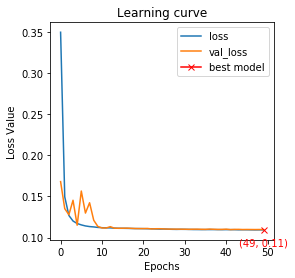

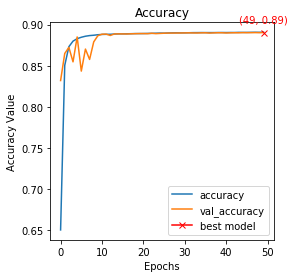

In [23]:
#Loss
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
xmin = np.argmin(clf_hist.history["val_loss"])
ymin = np.min(clf_hist.history["val_loss"])
plt.plot( xmin, ymin, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmin) + ', '+ str(round(ymin, 2)) + ')', xy = (xmin, ymin - 0.01),
             horizontalalignment = "center", verticalalignment = "top", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();


#Accuracy
plt.figure(figsize=(4, 4))
plt.title("Accuracy")
plt.plot(clf_hist.history["dice_coef"], label="accuracy")
plt.plot(clf_hist.history["val_dice_coef"], label="val_accuracy")
xmax = np.argmax(clf_hist.history["val_dice_coef"])
ymax = np.max(clf_hist.history["val_dice_coef"])
plt.plot( xmax, ymax, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmax) + ', '+ str(round(ymax,2)) + ')', xy = (xmax, ymax + 0.01),
             horizontalalignment = "center", verticalalignment = "bottom", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Value")
plt.legend();


# TASK2B

In [26]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Data augmentation

In [28]:
#Train dataset
image_datagen = ImageDataGenerator(rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range=0.1,
                                   zoom_range = 0.2,
                                   horizontal_flip=True)

mask_datagen = ImageDataGenerator(rotation_range = 10,
                                  width_shift_range = 0.1,
                                  height_shift_range=0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip=True)

# image_datagen.fit(x_train, augment=True, seed = 0)
# mask_datagen.fit(y_train, augment=True, seed = 0)
x_train_flow = image_datagen.flow(x_train, batch_size=batch_size, seed = 0)
y_train_flow = mask_datagen.flow(y_train, batch_size=batch_size, seed = 0)


#Test dataset
image_val_datagen = ImageDataGenerator()
mask_val_datagen = ImageDataGenerator()

# image_val_datagen.fit(x_train, augment=True, seed = 0)
# mask_val_datagen.fit(y_train, augment=True, seed = 0)
x_test_flow = image_val_datagen.flow(x_test, batch_size=batch_size, seed = 0)
y_test_flow = mask_val_datagen.flow(y_test, batch_size=batch_size, seed = 0)



train_generator = (pair for pair in zip(x_train_flow, y_train_flow))
val_generator = (pair for pair in zip(x_test_flow, y_test_flow))

# Train the model

In [34]:
clf.compile(loss=[dice_coef_loss], optimizer = Adam(lr = LR), metrics=[dice_coef, Precision(), Recall()])  
clf_hist = clf.fit_generator(train_generator, epochs = n_epochs, validation_data=val_generator, steps_per_epoch=5, validation_steps=10)

Epoch 1/50
5/5 [==============================] - 20s 4s/step - loss: 0.1389 - dice_coef: 0.8611 - precision: 0.9991 - recall_1: 0.8501 - val_loss: 0.1091 - val_dice_coef: 0.8909 - val_precision: 0.9998 - val_recall_1: 0.9391
Epoch 2/50
5/5 [==============================] - 0s 98ms/step - loss: 0.1148 - dice_coef: 0.8852 - precision: 0.9928 - recall_1: 0.9135 - val_loss: 0.1063 - val_dice_coef: 0.8937 - val_precision: 0.9999 - val_recall_1: 0.9384
Epoch 3/50
5/5 [==============================] - 1s 100ms/step - loss: 0.1701 - dice_coef: 0.8299 - precision: 0.9594 - recall_1: 0.8326 - val_loss: 0.1169 - val_dice_coef: 0.8831 - val_precision: 0.9854 - val_recall_1: 0.9382
Epoch 4/50
5/5 [==============================] - 1s 100ms/step - loss: 0.2718 - dice_coef: 0.7282 - precision: 0.8009 - recall_1: 0.7896 - val_loss: 0.1107 - val_dice_coef: 0.8893 - val_precision: 0.9946 - val_recall_1: 0.9346
Epoch 5/50
5/5 [==============================] - 0s 99ms/step - loss: 0.3225 - dice_coef: 

Epoch 37/50
5/5 [==============================] - 1s 114ms/step - loss: 0.3523 - dice_coef: 0.6477 - precision: 0.7513 - recall_1: 0.6824 - val_loss: 0.1101 - val_dice_coef: 0.8899 - val_precision: 0.9991 - val_recall_1: 0.9462
Epoch 38/50
5/5 [==============================] - 1s 109ms/step - loss: 0.3008 - dice_coef: 0.6992 - precision: 0.8010 - recall_1: 0.7300 - val_loss: 0.1083 - val_dice_coef: 0.8917 - val_precision: 0.9986 - val_recall_1: 0.9515
Epoch 39/50
5/5 [==============================] - 1s 115ms/step - loss: 0.3131 - dice_coef: 0.6869 - precision: 0.7878 - recall_1: 0.7204 - val_loss: 0.1100 - val_dice_coef: 0.8900 - val_precision: 0.9983 - val_recall_1: 0.9528
Epoch 40/50
5/5 [==============================] - 1s 109ms/step - loss: 0.3125 - dice_coef: 0.6875 - precision: 0.7805 - recall_1: 0.7180 - val_loss: 0.1133 - val_dice_coef: 0.8867 - val_precision: 0.9930 - val_recall_1: 0.9518
Epoch 41/50
5/5 [==============================] - 1s 114ms/step - loss: 0.2969 - di

# Get the result Dice_coef

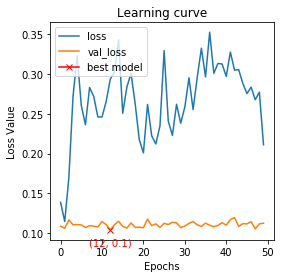

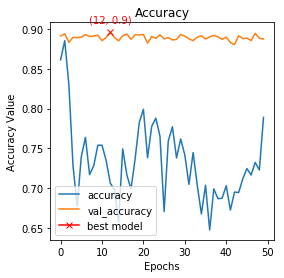

In [36]:
#Loss
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
xmin = np.argmin(clf_hist.history["val_loss"])
ymin = np.min(clf_hist.history["val_loss"])
plt.plot( xmin, ymin, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmin) + ', '+ str(round(ymin, 2)) + ')', xy = (xmin, ymin - 0.01),
             horizontalalignment = "center", verticalalignment = "top", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();


#Accuracy
plt.figure(figsize=(4, 4))
plt.title("Accuracy")
plt.plot(clf_hist.history["dice_coef"], label="accuracy")
plt.plot(clf_hist.history["val_dice_coef"], label="val_accuracy")
xmax = np.argmax(clf_hist.history["val_dice_coef"])
ymax = np.max(clf_hist.history["val_dice_coef"])
plt.plot( xmax, ymax, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmax) + ', '+ str(round(ymax,2)) + ')', xy = (xmax, ymax + 0.01),
             horizontalalignment = "center", verticalalignment = "bottom", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Value")
plt.legend();


# Get the precision and recall

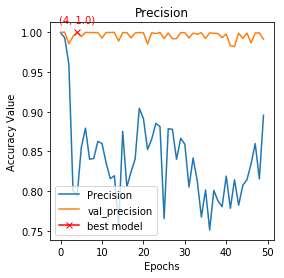

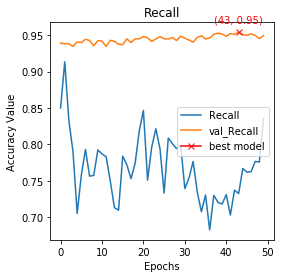

In [43]:
#Precision
plt.figure(figsize=(4, 4))
plt.title("Precision")
plt.plot(clf_hist.history["precision"], label="Precision")
plt.plot(clf_hist.history["val_precision"], label="val_precision")
xmax = np.argmax(clf_hist.history["val_precision"])
ymax = np.max(clf_hist.history["val_precision"])
plt.plot( xmax, ymax, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmax) + ', '+ str(round(ymax,2)) + ')', xy = (xmax, ymax + 0.01),
             horizontalalignment = "center", verticalalignment = "bottom", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Value")
plt.legend();

# Recall
plt.figure(figsize=(4, 4))
plt.title("Recall")
plt.plot(clf_hist.history["recall_1"], label="Recall")
plt.plot(clf_hist.history["val_recall_1"], label="val_Recall")
xmax = np.argmax(clf_hist.history["val_recall_1"])
ymax = np.max(clf_hist.history["val_recall_1"])
plt.plot( xmax, ymax, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmax) + ', '+ str(round(ymax,2)) + ')', xy = (xmax, ymax + 0.01),
             horizontalalignment = "center", verticalalignment = "bottom", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Value")
plt.legend();

# TASK3

# modify the U net

In [5]:
def get_unet(img_ch, img_width, img_height, n_filters, dropout, batch_normalization,
             max_pooling = True, binary = False, class_num=3):
    inputs = Input(shape=(img_width, img_height, img_ch))
    c1,cblock1 = conv_block(inputs, n_filters * 1, dropout, max_pooling, batch_normalization) 
    c2,cblock2 = conv_block(cblock1, n_filters * 2, dropout, max_pooling, batch_normalization)
    c3,cblock3 = conv_block(cblock2, n_filters * 4, dropout, max_pooling, batch_normalization)
    c4,cblock4 = conv_block(cblock3, n_filters * 8, dropout, max_pooling, batch_normalization)
    ## Nottlenect block
    temp,cblock5 = conv_block(cblock4, n_filters * 16, dropout, False, False)
    ## Decoder 
    cblock6 = decoder_block(cblock5, n_filters * 8, dropout, c4, batch_normalization)
    cblock7 = decoder_block(cblock6, n_filters * 4, dropout, c3, batch_normalization)
    cblock8 = decoder_block(cblock7, n_filters * 2, dropout, c2, batch_normalization)
    cblock9 = decoder_block(cblock8, n_filters * 1, dropout, c1, batch_normalization)
    #Output
    if binary:
        out = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same', activation = 'sigmoid')(cblock9)
    else:
        out = Conv2D(filters=class_num, kernel_size=(3,3), strides=(1,1), padding='same', activation = 'softmax')(cblock9)
        
    clf = Model(inputs=inputs, outputs=out)
    clf.summary()
    
    return clf    

# Data loading

In [6]:
import os
import numpy as np
from random import shuffle
from skimage.io import imread
from skimage.transform import resize

In [7]:
def get_mask(data_path, mask_labels, img_h, img_w, split_ratio):
    """
    Parameters
    ----------
    data_path : Str
        Path to the data directory
    mask_labels : List
        A list containing the name of the mask files.
    img_h : Int
        image height to be resized to.
    img_w : Int
        image width to be resized to.    
    split_ratio : Float
        Ratio between 0 and 1 giving the proportion of train 
    Returns
    -------
    mask : List
        A list containing the mask images along with their
        corresponding labels.
    """
    
    mask_list = []
    for label in mask_labels:
        mask = imread(data_path + 'Mask/' + label, as_gray = True) # "as_grey"
        mask = resize(mask, (img_h, img_w), anti_aliasing = True).astype('float32')
        mask_list.append([np.array(mask), label])
    shuffle(mask_list)
    train_mask_list = mask_list[:int(split_ratio*len(mask_list))]
    test_mask_list = mask_list[int(split_ratio*len(mask_list)):]
    return train_mask_list, test_mask_list


def get_data(data_path, mask_labels, img_h, img_w, split_ratio = 0.8):
    
    #Loading the shuffled and splitted lists of mask images with their corresponding labels
    train_mask_list, test_mask_list = get_mask(data_path, mask_labels, img_h, img_w, split_ratio)
    
    #Initialising the train arrays
    train_img = np.zeros((len(train_mask_list), img_h, img_w), dtype = np.float32)
    train_mask = np.zeros((len(train_mask_list), img_h, img_w), dtype = np.float32)
    for ind in range(len(train_mask_list)):
        #Adding the mask in the ytrain array
        train_mask[ind] = train_mask_list[ind][0]
        #Adding the corresponding image in the xtrain array
        label = train_mask_list[ind][1]
        label_image = label[0:-9] + '.png'
        img = imread(data_path + 'Image/' + label_image, as_gray = True) # "as_grey"
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        train_img[ind] = (np.array(img)-np.min(np.array(img)))/(np.max(np.array(img))-np.min(np.array(img)))
        #Print the advancement
        if ind%10==0:
            a = ind/len(train_mask_list)
            print('Train dataset : ', str(int(100*a)), '%')
        elif ind+1 == len(train_mask_list):
            print('Train dataset : 100%')
    train_img = np.expand_dims(train_img, axis =3)
    train_mask = np.expand_dims(train_mask, axis =3)
    
    #Initialising the test arrays
    test_img = np.zeros((len(test_mask_list), img_h, img_w), dtype = np.float32)
    test_mask = np.zeros((len(test_mask_list), img_h, img_w), dtype = np.float32)
    for ind in range(len(test_mask_list)):
        #Adding the mask in the ytest array
        test_mask[ind] = test_mask_list[ind][0]
        #Adding the corresponding image in the xtest array
        label = test_mask_list[ind][1]
        label_image = label[0:-9] + '.png'
        img = imread(data_path + 'Image/' + label_image, as_gray = True) # "as_grey"
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        test_img[ind] = (np.array(img)-np.min(np.array(img)))/(np.max(np.array(img))-np.min(np.array(img)))
        #Print the advancement
        if ind%10==0:
            a = ind/len(test_mask_list)
            print('Test dataset : ', str(int(100*a)), '%')
        elif ind+1 == len(test_mask_list):
            print('Test dataset : 100%')

    test_img = np.expand_dims(test_img, axis =3)
    test_mask = np.expand_dims(test_mask, axis =3)
    
    return train_img, train_mask, test_img, test_mask, img
    
    

In [8]:
img_w, img_h = 256, 256 
data_path = '/DL_course_data/Lab3/CT/'
mask_labels = os.listdir(data_path + 'Mask/')
x_train, y_train, x_test, y_test, test_img = get_data(data_path, mask_labels, img_h, img_w, split_ratio = 0.8)

Train dataset :  0 %
Train dataset :  0 %
Train dataset :  0 %
Train dataset :  0 %
Train dataset :  0 %
Train dataset :  0 %
Train dataset :  0 %
Train dataset :  1 %
Train dataset :  1 %
Train dataset :  1 %
Train dataset :  1 %
Train dataset :  1 %
Train dataset :  1 %
Train dataset :  1 %
Train dataset :  2 %
Train dataset :  2 %
Train dataset :  2 %
Train dataset :  2 %
Train dataset :  2 %
Train dataset :  2 %
Train dataset :  2 %
Train dataset :  3 %
Train dataset :  3 %
Train dataset :  3 %
Train dataset :  3 %
Train dataset :  3 %
Train dataset :  3 %
Train dataset :  4 %
Train dataset :  4 %
Train dataset :  4 %
Train dataset :  4 %
Train dataset :  4 %
Train dataset :  4 %
Train dataset :  4 %
Train dataset :  5 %
Train dataset :  5 %
Train dataset :  5 %
Train dataset :  5 %
Train dataset :  5 %
Train dataset :  5 %
Train dataset :  5 %
Train dataset :  6 %
Train dataset :  6 %
Train dataset :  6 %
Train dataset :  6 %
Train dataset :  6 %
Train dataset :  6 %
Train dataset

Train dataset :  55 %
Train dataset :  55 %
Train dataset :  56 %
Train dataset :  56 %
Train dataset :  56 %
Train dataset :  56 %
Train dataset :  56 %
Train dataset :  56 %
Train dataset :  57 %
Train dataset :  57 %
Train dataset :  57 %
Train dataset :  57 %
Train dataset :  57 %
Train dataset :  57 %
Train dataset :  57 %
Train dataset :  58 %
Train dataset :  58 %
Train dataset :  58 %
Train dataset :  58 %
Train dataset :  58 %
Train dataset :  58 %
Train dataset :  58 %
Train dataset :  59 %
Train dataset :  59 %
Train dataset :  59 %
Train dataset :  59 %
Train dataset :  59 %
Train dataset :  59 %
Train dataset :  59 %
Train dataset :  60 %
Train dataset :  60 %
Train dataset :  60 %
Train dataset :  60 %
Train dataset :  60 %
Train dataset :  60 %
Train dataset :  61 %
Train dataset :  61 %
Train dataset :  61 %
Train dataset :  61 %
Train dataset :  61 %
Train dataset :  61 %
Train dataset :  61 %
Train dataset :  62 %
Train dataset :  62 %
Train dataset :  62 %
Train data

Test dataset :  46 %
Test dataset :  46 %
Test dataset :  47 %
Test dataset :  48 %
Test dataset :  48 %
Test dataset :  49 %
Test dataset :  49 %
Test dataset :  50 %
Test dataset :  51 %
Test dataset :  51 %
Test dataset :  52 %
Test dataset :  52 %
Test dataset :  53 %
Test dataset :  54 %
Test dataset :  54 %
Test dataset :  55 %
Test dataset :  55 %
Test dataset :  56 %
Test dataset :  57 %
Test dataset :  57 %
Test dataset :  58 %
Test dataset :  58 %
Test dataset :  59 %
Test dataset :  59 %
Test dataset :  60 %
Test dataset :  61 %
Test dataset :  61 %
Test dataset :  62 %
Test dataset :  62 %
Test dataset :  63 %
Test dataset :  64 %
Test dataset :  64 %
Test dataset :  65 %
Test dataset :  65 %
Test dataset :  66 %
Test dataset :  67 %
Test dataset :  67 %
Test dataset :  68 %
Test dataset :  68 %
Test dataset :  69 %
Test dataset :  70 %
Test dataset :  70 %
Test dataset :  71 %
Test dataset :  71 %
Test dataset :  72 %
Test dataset :  73 %
Test dataset :  73 %
Test dataset 

In [9]:
y_test.shape


(1684, 256, 256, 1)

# Define the model

In [10]:
Base = 8
dropout = 0.2
batch_norm = True
train_percentage = 0.8
LR = 1e-4
batch_size = 8
img_ch = 1
img_w = 256
img_h = 256
n_epochs = 80
clf = get_unet(img_ch, img_w, img_h, Base, dropout, batch_norm)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2 (BatchNo (None, 256, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 8)  0           batch_normalization_v2[0][0]     
______________________________________________________________________________________________

# Data augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
#Train dataset
image_datagen = ImageDataGenerator(rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range=0.1,
                                   zoom_range = 0.2,
                                   horizontal_flip=True)

mask_datagen = ImageDataGenerator(rotation_range = 10,
                                  width_shift_range = 0.1,
                                  height_shift_range=0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip=True)

# image_datagen.fit(x_train, augment=True, seed = 0)
# mask_datagen.fit(y_train, augment=True, seed = 0)
x_train_flow = image_datagen.flow(x_train, batch_size=batch_size, seed = 0)
y_train_flow = mask_datagen.flow(y_train, batch_size=batch_size, seed = 0)


#Test dataset
image_val_datagen = ImageDataGenerator()
mask_val_datagen = ImageDataGenerator()

# image_val_datagen.fit(x_train, augment=True, seed = 0)
# mask_val_datagen.fit(y_train, augment=True, seed = 0)
x_test_flow = image_val_datagen.flow(x_test, batch_size=batch_size, seed = 0)
y_test_flow = mask_val_datagen.flow(y_test, batch_size=batch_size, seed = 0)



train_generator = (pair for pair in zip(x_train_flow, y_train_flow))
val_generator = (pair for pair in zip(x_test_flow, y_test_flow))

In [15]:
from tensorflow.keras.optimizers import Adam
clf.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(lr = LR), metrics=['accuracy'])  
clf_hist = clf.fit_generator(train_generator, epochs = n_epochs, validation_data=val_generator, steps_per_epoch=5, validation_steps=10)

Epoch 1/80
5/5 [==============================] - 16s 3s/step - loss: 0.9631 - accuracy: 0.4160 - val_loss: 1.0732 - val_accuracy: 0.5489
Epoch 2/80
5/5 [==============================] - 1s 102ms/step - loss: 0.9383 - accuracy: 0.4920 - val_loss: 1.0644 - val_accuracy: 0.5581
Epoch 3/80
5/5 [==============================] - 1s 105ms/step - loss: 0.9128 - accuracy: 0.4918 - val_loss: 1.0559 - val_accuracy: 0.4948
Epoch 4/80
5/5 [==============================] - 1s 107ms/step - loss: 0.8881 - accuracy: 0.5099 - val_loss: 1.0475 - val_accuracy: 0.4616
Epoch 5/80
5/5 [==============================] - 1s 104ms/step - loss: 0.8607 - accuracy: 0.5023 - val_loss: 1.0393 - val_accuracy: 0.4717
Epoch 6/80
5/5 [==============================] - 1s 104ms/step - loss: 0.8365 - accuracy: 0.5188 - val_loss: 1.0298 - val_accuracy: 0.4945
Epoch 7/80
5/5 [==============================] - 1s 103ms/step - loss: 0.8127 - accuracy: 0.5301 - val_loss: 1.0193 - val_accuracy: 0.5187
Epoch 8/80
5/5 [======

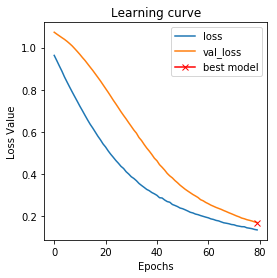

the minimum var_loss is 0.16867037415504454
the Best epoch nr is 79
the maximum var_accuracy is 0.7586395
the maximum train_accuracy is 0.76391906
the Best epoch nr is 53


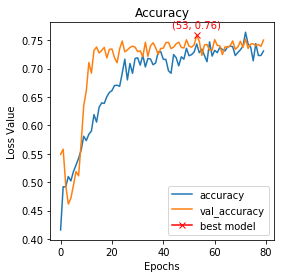

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(clf_hist.history["val_loss"]),
     np.min(clf_hist.history["val_loss"]),
     marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.show()
print('the minimum var_loss is', np.min(clf_hist.history["val_loss"]))
print('the Best epoch nr is', np.argmin(clf_hist.history["val_loss"]))

#Accuracy
plt.figure(figsize=(4, 4))
plt.title("Accuracy")
plt.plot(clf_hist.history["accuracy"], label="accuracy")
plt.plot(clf_hist.history["val_accuracy"], label="val_accuracy")
xmax = np.argmax(clf_hist.history["val_accuracy"])
ymax = np.max(clf_hist.history["val_accuracy"])
plt.plot( xmax, ymax, marker="x", color="r", label="best model")
plt.annotate('(' + str(xmax) + ', '+ str(round(ymax,2)) + ')', xy = (xmax, ymax + 0.01),
             horizontalalignment = "center", verticalalignment = "bottom", color = "red")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
print('the maximum var_accuracy is', np.max(clf_hist.history["val_accuracy"]))
print('the maximum train_accuracy is', np.max(clf_hist.history["accuracy"]))
print('the Best epoch nr is', xmax)